In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.ndimage import sobel
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load and display image

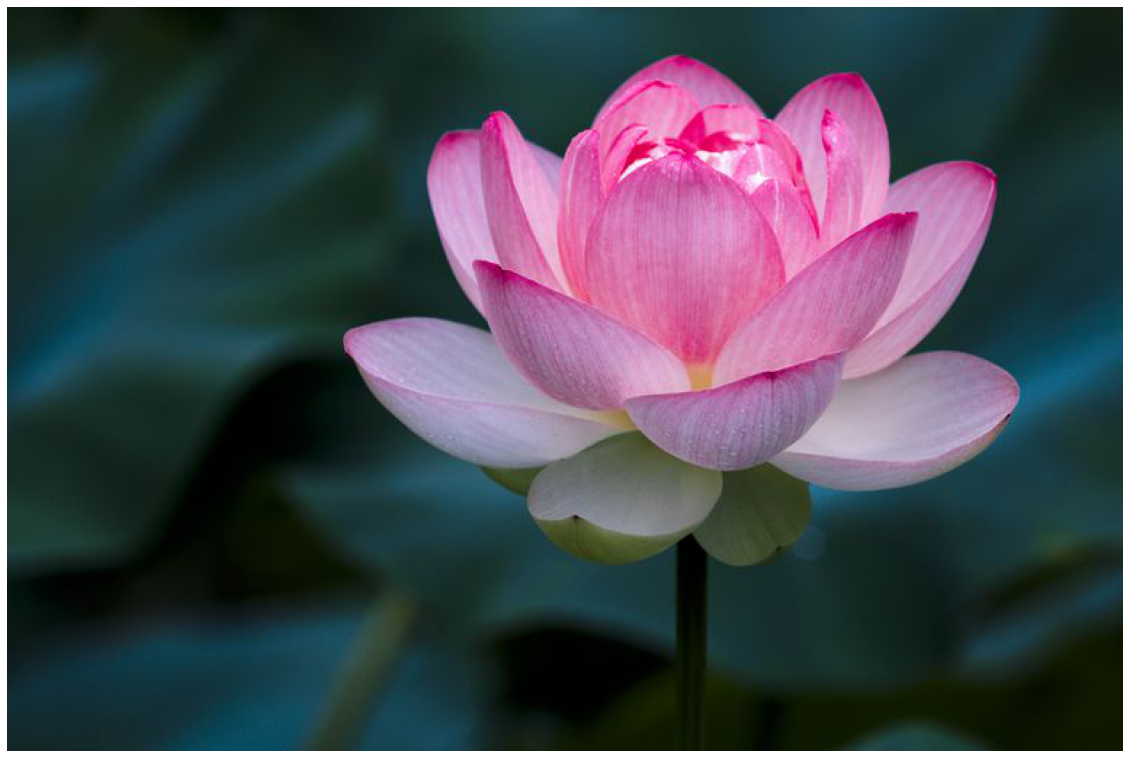

In [2]:
img = plt.imread('lotus-flower.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

### a.) Convert to grayscale

In [3]:
### Color to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype('float32')

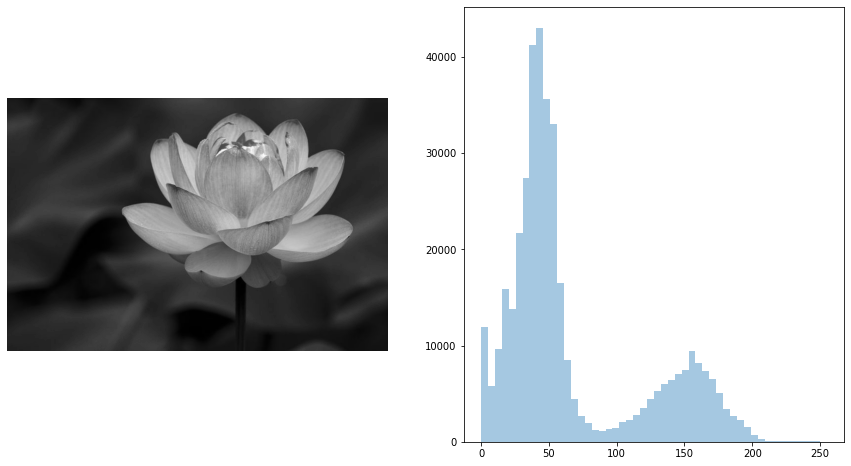

In [4]:
plt.subplots(nrows=1, ncols=2, figsize=(15,8))

plt.subplot(121)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

plt.subplot(122)
sns.distplot(gray.reshape(-1), kde=False)
plt.show()

### b.) Thresholding

In [5]:
def bnw(image, thresh):
    img = image.copy()
    img[img <= thresh] = 0
    img[img > thresh] = 1
    
    return img

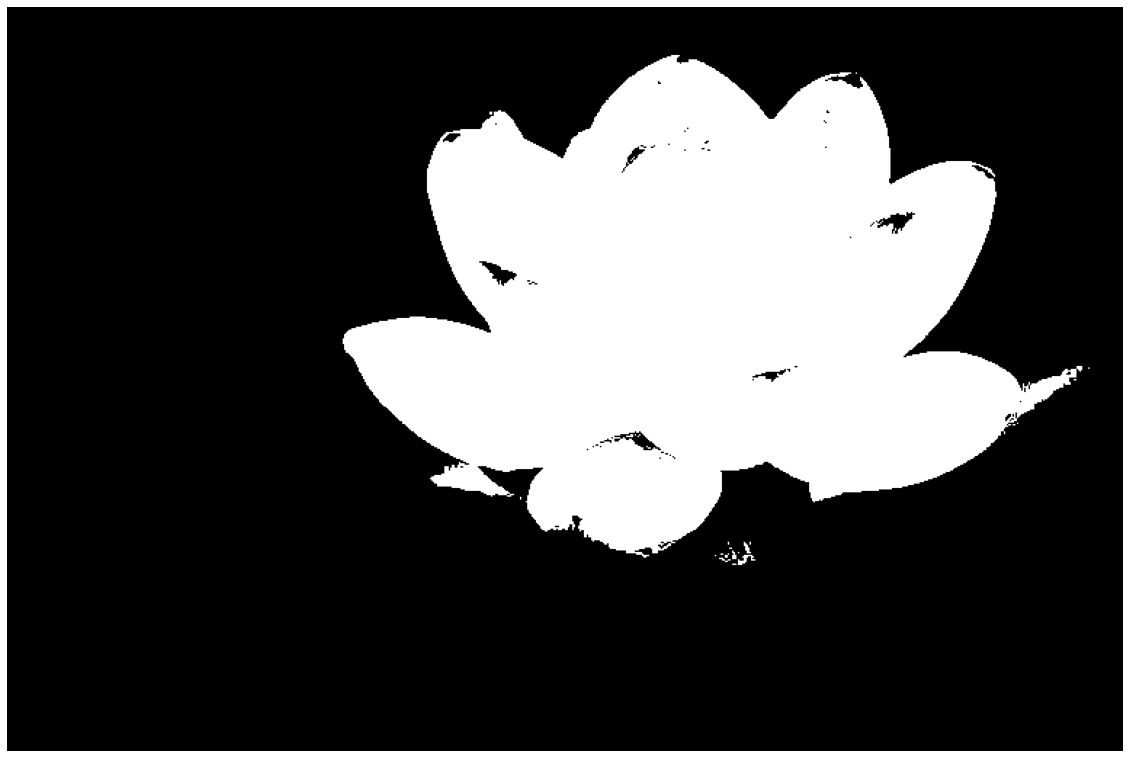

In [6]:

bw_img = bnw(gray, 75)

plt.figure(figsize=(20,15))
plt.imshow(bw_img, cmap='gray')
plt.axis('off')
plt.show()

### c.) Brightness shift

In [7]:
def pixelshift(image, s):
    img = image.copy()
    img += s
    img[img>255] = 255
    img[img<0] = 0
    return img

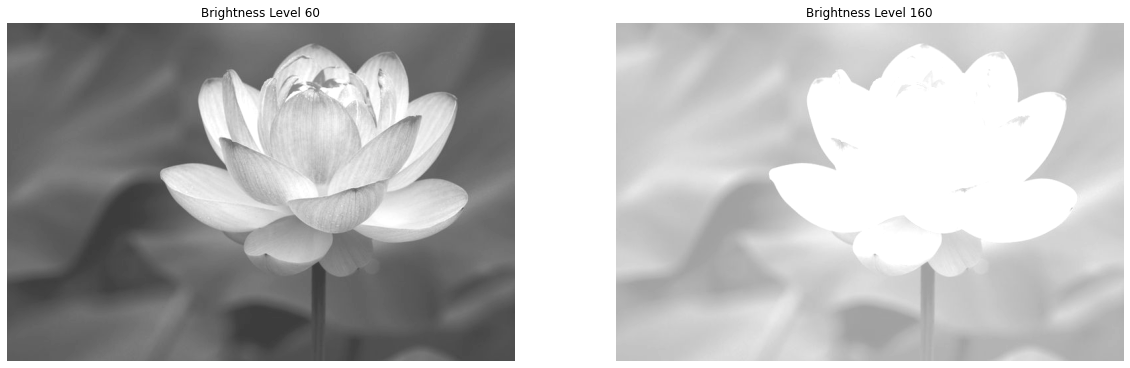

In [8]:
bright60 = pixelshift(gray, 60)
bright160 = pixelshift(gray, 160)

plt.subplots(nrows=1, ncols=2, figsize=(20,15))
plt.subplot(121)
plt.imshow(bright60, cmap='gray', vmin=0, vmax=255)
plt.title('Brightness Level 60')
plt.axis('off')

plt.subplot(122)
plt.imshow(bright160, cmap='gray', vmin=0, vmax=255)
plt.title("Brightness Level 160")
plt.axis('off')
plt.show()

### d.) Otsu's method

In [9]:
ret,th = cv2.threshold(gray.astype('uint8'),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

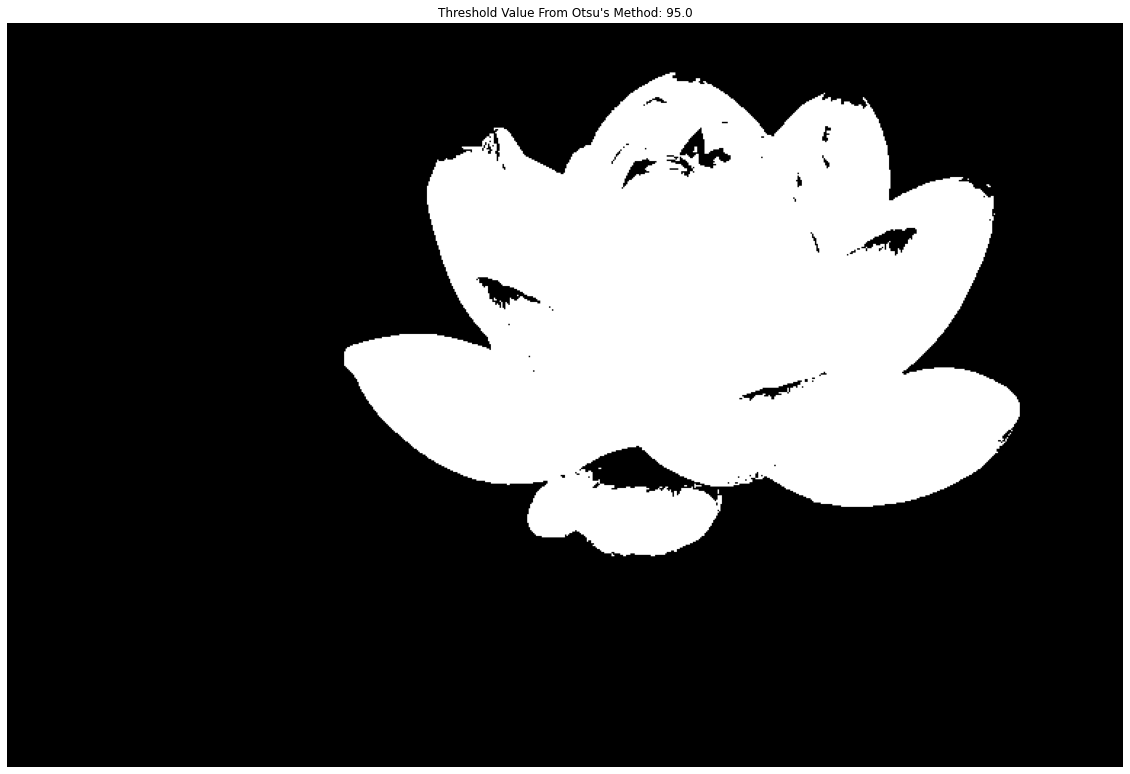

In [10]:
plt.figure(figsize=(20,15))
plt.imshow(th, cmap='gray')
plt.title("Threshold Value From Otsu's Method: {}".format(ret))
plt.axis('off')
plt.show()

#### Otsu's result
Otsu's method return a threshold of 95. This is very close to the threshold of 75 which I manually chose. While sufficient for means of automation, Otsu's method did leave out bits of the leaf to the bottom right of the image, where my threshold of 75 captured a bit of it

### e.) K-Means Clustering

In [11]:
from sklearn.cluster import KMeans

In [12]:
img_transform = img.copy()
col1 = img_transform[:,:,0].ravel().reshape(-1,1)
col2 = img_transform[:,:,1].ravel().reshape(-1,1)
col3 = img_transform[:,:,2].ravel().reshape(-1,1)

Xtrain = np.concatenate([col1, col2, col3], axis=1)

### Warning: 
The cell below runs from 1 to 10 KMeans Clusters fit. This could take some time, especially if not on a powerful laptop/computer.

In [13]:
classifications = []
for i in range(1,11):
    
    clf = KMeans(n_clusters = i)
    clf.fit(Xtrain)
    classifications.append(clf.predict(Xtrain).reshape(img.shape[0], img.shape[1]))

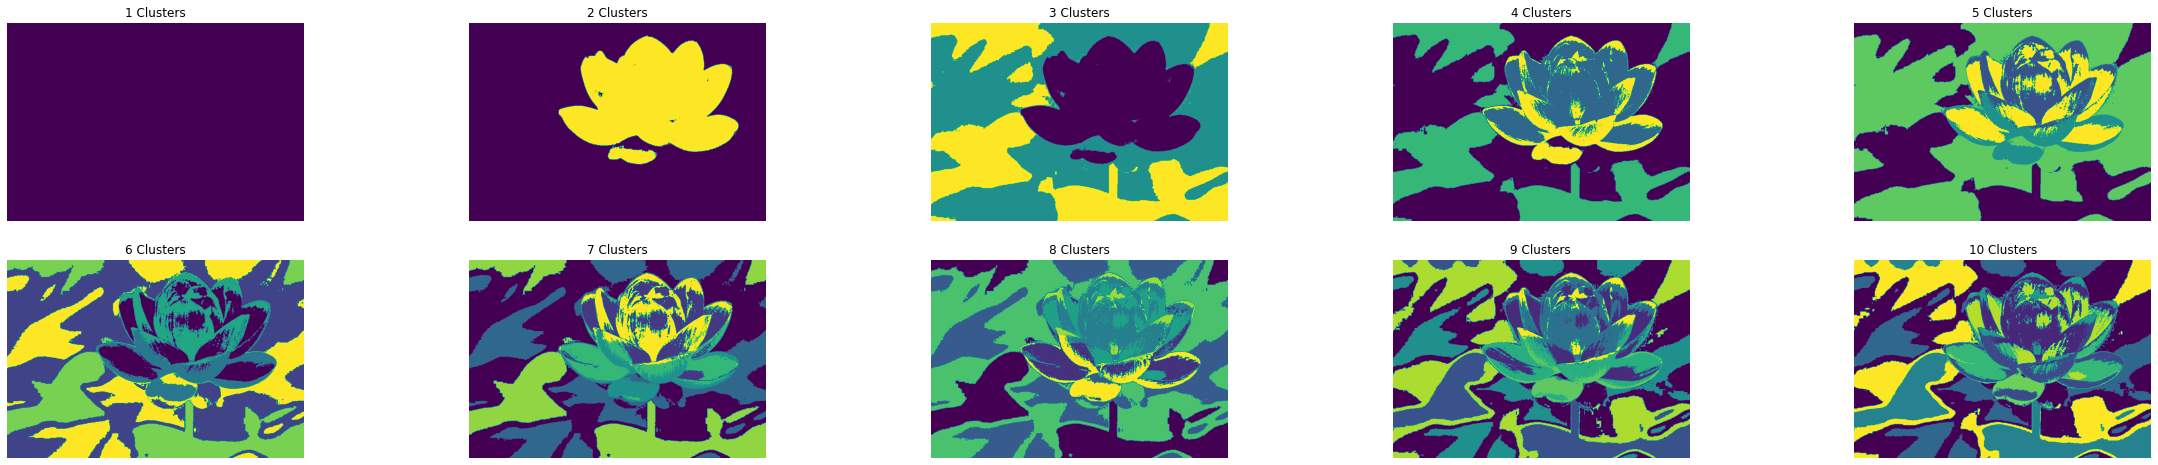

In [14]:
plt.subplots(nrows=4, ncols=5, figsize=(40,8))

for i in range(1,11):
    
    plt.subplot(2,5,int('{}'.format(i)))
    plt.imshow(classifications[i-1])
    plt.axis('off')
    plt.title('{} Clusters'.format(i))
    
plt.show()

### f.) Sobel operator

In [15]:
sob = sobel(gray)
sob[sob<0] = 0

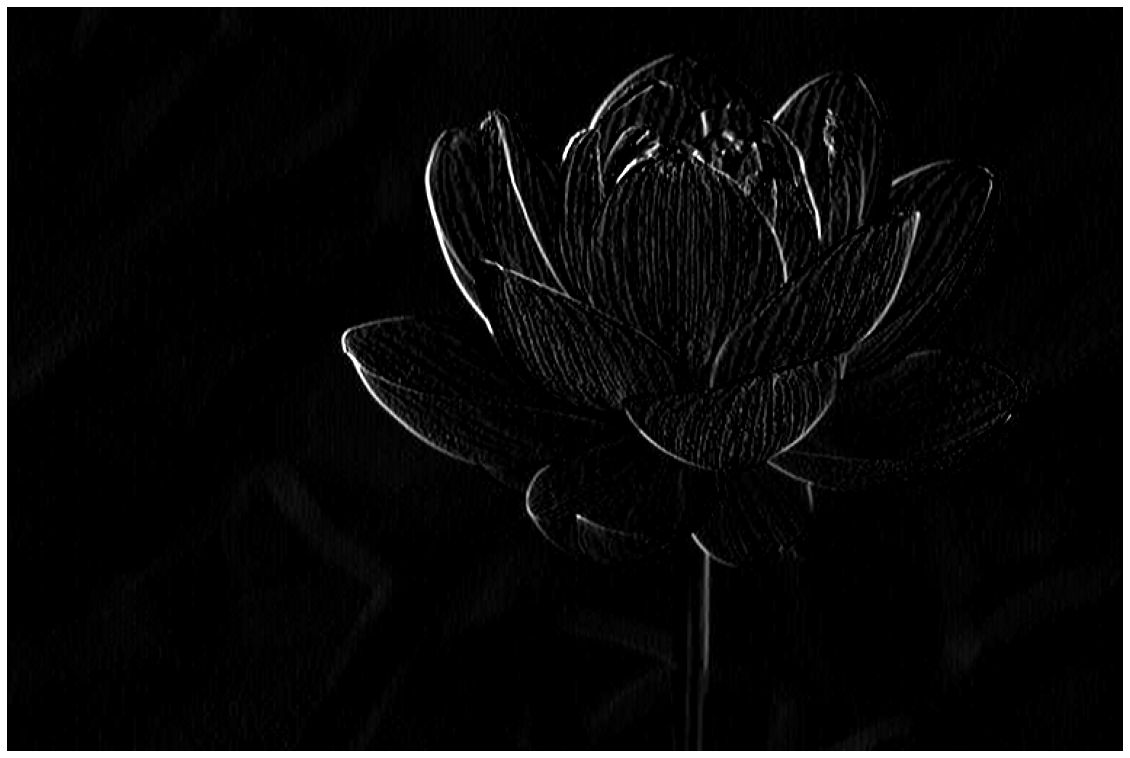

In [16]:
plt.figure(figsize=(20,15))
plt.imshow(sob, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [17]:
def bnw(image, thresh):
    img = image.copy()
    img[img <= thresh] = 0
    img[img > thresh] = 1
    
    return img

In [18]:
sobs = []
for i in range(10,101, 10):
    im = bnw(sob, i)
    sobs.append(im)

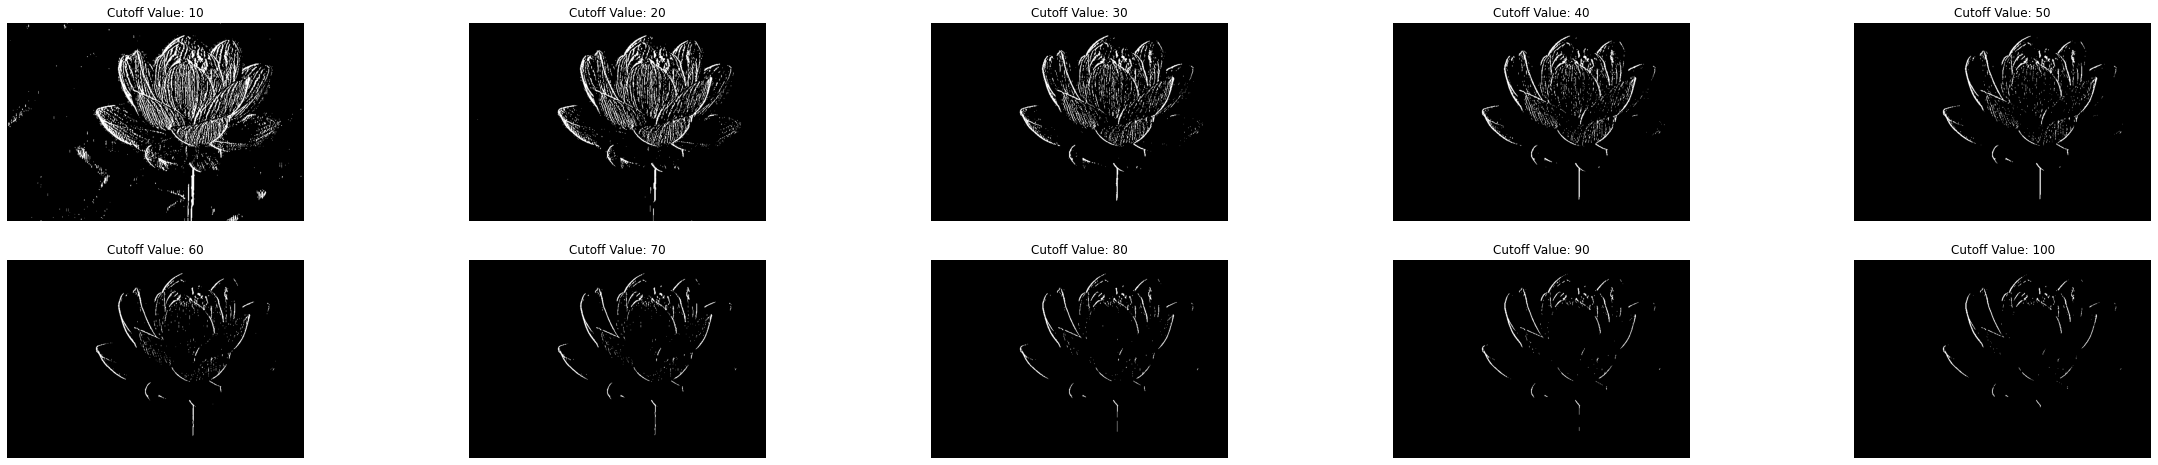

In [19]:
plt.subplots(nrows=2, ncols=5, figsize=(40,8))
for i in range(len(sobs)):
    plt.subplot(2,5,int('{}'.format(i+1)))
    plt.imshow(sobs[i], cmap='gray')
    plt.title('Cutoff Value: {}'.format((i+1)*10))
    plt.axis('off')
    
plt.show()


### Result
At lower cutoff values, the Sobel filter has detected charactersitics in the petals and the surround background as edges. As the cutoff value is increased, the more "subtle" edges are filtered out, leaving only the more dominant edges of the flower itself. As the cutoff is increased to even higher values, only the most obvious edges of the flower are preserved

### g.) Apply another filter

Attempting to apply the Kirsch Filter to the color image

In [20]:
def kirsch(chan):

    d1 = np.array([[ 5,  5,  5], [-3,  0, -3],[-3, -3, -3]], dtype=np.float32)
    d2 = np.array([[ 5,  5, -3],[ 5,  0, -3],[-3, -3, -3]], dtype=np.float32)
    d3 = np.array([[ 5, -3, -3], [ 5,  0, -3],[ 5, -3, -3]], dtype=np.float32)
    d4 = np.array([[-3, -3, -3],[ 5,  0, -3],[ 5,  5, -3]], dtype=np.float32)
    d5 = np.array([[-3, -3, -3],[-3,  0, -3],[ 5,  5,  5]], dtype=np.float32)
    d6 = np.array([[-3, -3, -3],[-3,  0,  5], [-3,  5,  5]], dtype=np.float32)
    d7 = np.array([[-3, -3,  5],[-3,  0,  5],[-3, -3,  5]], dtype=np.float32)
    d8 = np.array([[-3,  5,  5], [-3,  0,  5],[-3, -3, -3]], dtype=np.float32)

    g1 = cv2.normalize(cv2.filter2D(chan, cv2.CV_32F, d1), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    g2 = cv2.normalize(cv2.filter2D(chan, cv2.CV_32F, d2), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    g3 = cv2.normalize(cv2.filter2D(chan, cv2.CV_32F, d3), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    g4 = cv2.normalize(cv2.filter2D(chan, cv2.CV_32F, d4), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    g5 = cv2.normalize(cv2.filter2D(chan, cv2.CV_32F, d5), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    g6 = cv2.normalize(cv2.filter2D(chan, cv2.CV_32F, d6), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    g7 = cv2.normalize(cv2.filter2D(chan, cv2.CV_32F, d7), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    g8 = cv2.normalize(cv2.filter2D(chan, cv2.CV_32F, d8), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    magn = cv2.max(g1, cv2.max(g2, cv2.max(g3, cv2.max(g4, cv2.max(g5, cv2.max(g6, cv2.max(g7, g8)))))))
    return magn

In [21]:
chanR = img[:,:,0]
chanG = img[:,:,1]
chanB = img[:,:,2]

In [22]:
chanR_kirsch = kirsch(chanR)
chanG_kirsch = kirsch(chanG)
chanB_kirsch = kirsch(chanB)

In [23]:
img_kirsch = np.dstack([chanR_kirsch, chanG_kirsch, chanB_kirsch])

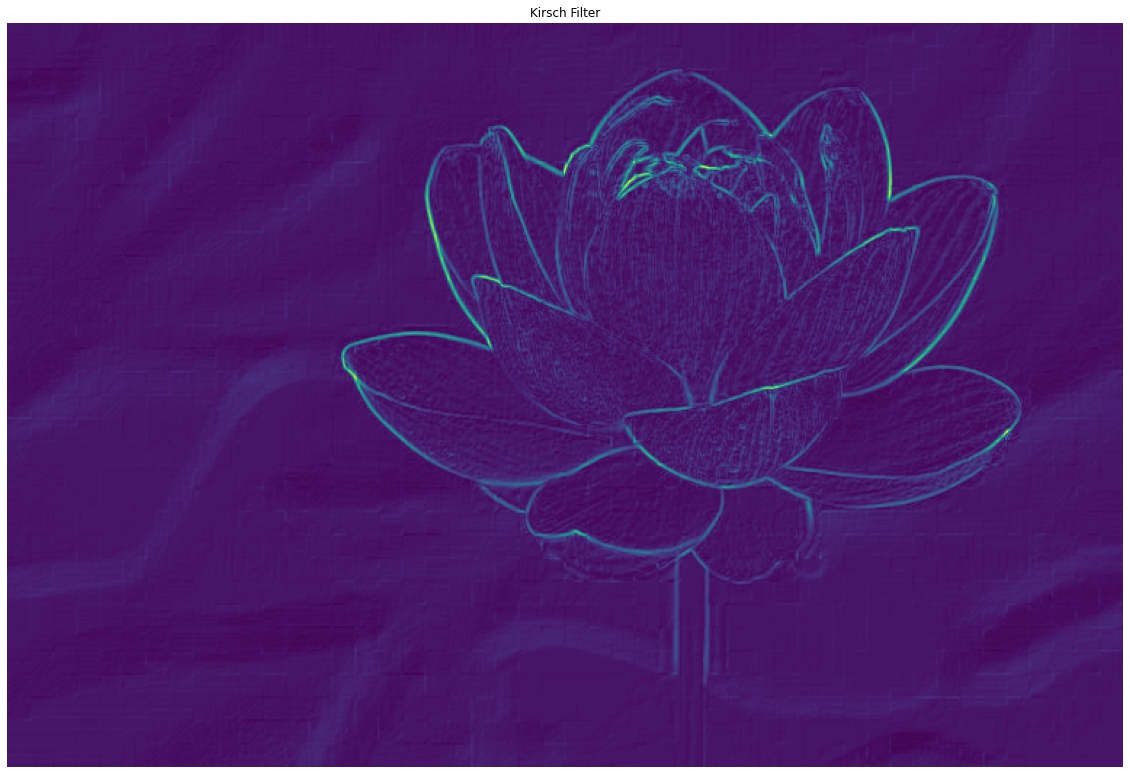

In [24]:
plt.figure(figsize=(20,15))
plt.imshow(chanB_kirsch)
plt.axis('off')
plt.title('Kirsch Filter')
plt.show()

### Result
The kirsch filter on the color image not only did a better job at detecting the edges compared to the sobel, but it is utilizing the different color channels to highlight the edges. Stronger edges (actual flower edges) are show to be more green in color, while the ligher edges (characteristics of the petals appear more bluish white). It was able to distinctly find the edges without the need for a user defined cutoff like the sobel implementation above